In [42]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from mlxtend.classifier import StackingClassifier


In [ ]:
# Load the Excel file
df = pd.read_excel('data1.xlsx',skiprows=1)
df.head(10)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [6]:
# Convert relevant columns to numeric
cols_to_convert = [
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Compute the averages for each transaction (row)
df['Bill'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
df['Pay'] = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)
df['Pay_Amt'] = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)

df.drop(columns=cols_to_convert, inplace=True)


In [7]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,default payment next month,Bill,Pay,Pay_Amt
0,1,20000,2,2,1,24,1,1284.000000,-0.333333,114.833333
1,2,120000,2,2,2,26,1,2846.166667,0.500000,833.333333
2,3,90000,2,2,2,34,0,16942.166667,0.000000,1836.333333
3,4,50000,2,2,1,37,0,38555.666667,0.000000,1398.000000
4,5,50000,1,2,1,57,0,18223.166667,-0.333333,9841.500000


In [13]:
# Perform Random Over Sampling manually
target_col = 'default payment next month'
df_majority = df[df[target_col] == 0]
df_minority = df[df[target_col] == 1]

# Oversample minority class
num_samples_to_add = len(df_majority) - len(df_minority)
df_oversampled = df_minority.sample(n=num_samples_to_add, replace=True, random_state=42)

# Combine original majority class with oversampled minority class
df_balanced = pd.concat([df_majority, df_minority, df_oversampled], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)


In [16]:
dummy = df_balanced['default payment next month'].tolist()
c,k=0,0
for i in range(0,len(dummy)):
    if dummy[i] == 1:
        c += 1
    else:
        k += 1
print (k)
print (c)

23364
23364


In [19]:
features = df_balanced.drop(columns=[target_col])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [20]:
X_features = list(df_balanced.columns)
X_features.remove('default payment next month')
X_features

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'Bill',
 'Pay',
 'Pay_Amt']

In [21]:
X = df_balanced[X_features]
Y = df_balanced['default payment next month']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, Y, test_size=0.2, random_state=42)

#### XGBoost

In [27]:
model = xgb.XGBClassifier(
    n_estimators=500, learning_rate=0.03, max_depth=8,  
    gamma=0.1, colsample_bytree=0.8, subsample=0.8,  
    reg_alpha=0.1, reg_lambda=1,  
    scale_pos_weight=1.5,  
    use_label_encoder=False, eval_metric='logloss'
)
model.fit(X_train,y_train) 

c:\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [29]:
print("XGBoost Classification Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Classification Metrics:
Accuracy: 0.7732719880162636
Precision: 0.7781155015197568
Recall: 0.7656483657338176
F1 Score: 0.771831592548724
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.77      4665
           1       0.78      0.77      0.77      4681

    accuracy                           0.77      9346
   macro avg       0.77      0.77      0.77      9346
weighted avg       0.77      0.77      0.77      9346



#### Stacking (RF + Gradient Boost + Logit)

In [30]:
# Define base models
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = GradientBoostingClassifier(n_estimators=100, random_state=42)
meta_clf = LogisticRegression()

# Stacking classifier
stacking_clf = StackingClassifier(classifiers=[clf1, clf2], meta_classifier=meta_clf)
stacking_clf.fit(X_train, y_train)

# Predictions
y_pred_stack = stacking_clf.predict(X_test)

In [31]:
print("\nStacking Classifier Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Precision:", precision_score(y_test, y_pred_stack))
print("Recall:", recall_score(y_test, y_pred_stack))
print("F1 Score:", f1_score(y_test, y_pred_stack))
print("Classification Report:\n", classification_report(y_test, y_pred_stack))


Stacking Classifier Metrics:
Accuracy: 0.9248876524716456
Precision: 0.8938823995248466
Recall: 0.9645374919888913
F1 Score: 0.9278668310727497
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      4665
           1       0.89      0.96      0.93      4681

    accuracy                           0.92      9346
   macro avg       0.93      0.92      0.92      9346
weighted avg       0.93      0.92      0.92      9346



In [33]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

### Random Forest Classifier

In [34]:
# Compute Metrics for Random Forest
print("\nRandom Forest Classification Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Classification Metrics:
Accuracy: 0.9248876524716456
Precision: 0.8938823995248466
Recall: 0.9645374919888913
F1 Score: 0.9278668310727497
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      4665
           1       0.89      0.96      0.93      4681

    accuracy                           0.92      9346
   macro avg       0.93      0.92      0.92      9346
weighted avg       0.93      0.92      0.92      9346



#### SVM Classification

In [37]:
# SVM Classification
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

In [38]:
# Compute Metrics for SVM
print("\nSVM Classification Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Classification Metrics:
Accuracy: 0.6934517440616307
Precision: 0.7388216728037875
Recall: 0.6000854518265328
F1 Score: 0.6622657078863611
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.79      0.72      4665
           1       0.74      0.60      0.66      4681

    accuracy                           0.69      9346
   macro avg       0.70      0.69      0.69      9346
weighted avg       0.70      0.69      0.69      9346



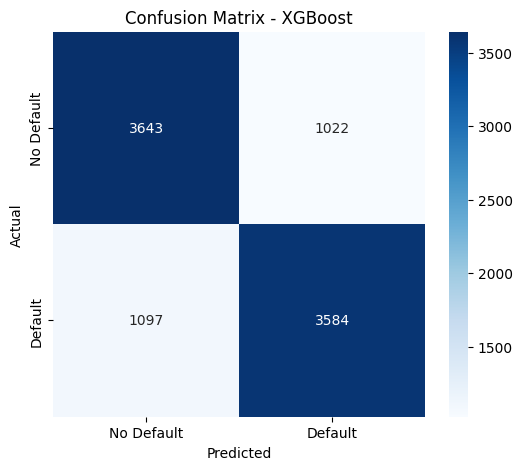

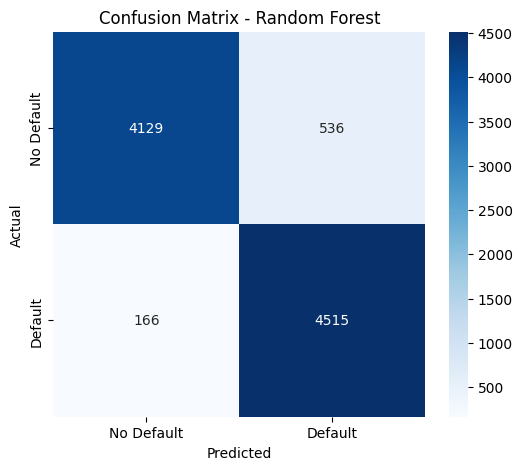

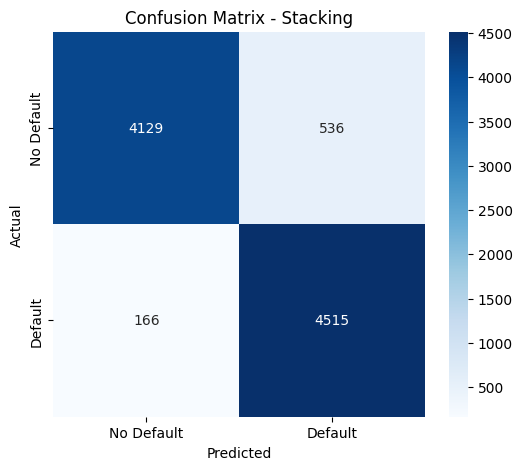

In [39]:
for model_name, y_pred in zip(["XGBoost", "Random Forest", "Stacking"], [y_pred_xgb, y_pred_rf, y_pred_stack]):
    plt.figure(figsize=(6, 5))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


#### Cross Validation

In [45]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Stacking": StackingClassifier(classifiers=[RandomForestClassifier(n_estimators=100, random_state=42), 
                                                 GradientBoostingClassifier(n_estimators=100, random_state=42)], 
                                    meta_classifier=LogisticRegression())
}



XGBoost Classification Metrics:


c:\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:31:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:31:36] WAR

Accuracy: 0.7778
Precision: 0.7787
Recall: 0.7762
F1 Score: 0.7774



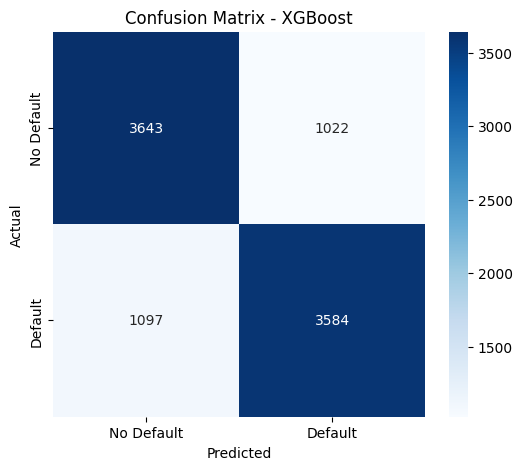


Random Forest Classification Metrics:
Accuracy: 0.9244
Precision: 0.8915
Recall: 0.9664
F1 Score: 0.9275



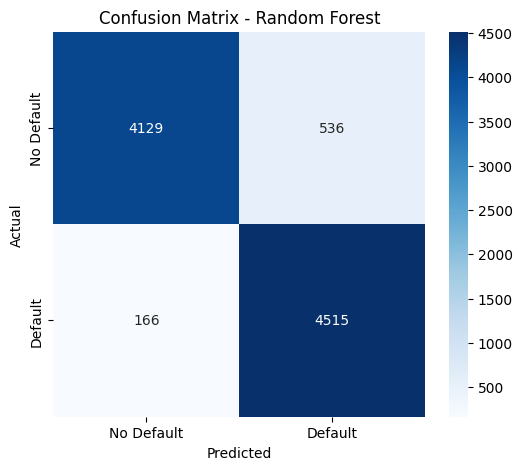


SVM Classification Metrics:


KeyboardInterrupt: 

In [46]:
for model_name, model in models.items():
    print(f"\n{model_name} Classification Metrics:")
    accuracy_scores = cross_val_score(model, features_scaled, Y, cv=skf, scoring='accuracy')
    precision_scores = cross_val_score(model, features_scaled, Y, cv=skf, scoring='precision')
    recall_scores = cross_val_score(model, features_scaled, Y, cv=skf, scoring='recall')
    f1_scores = cross_val_score(model, features_scaled, Y, cv=skf, scoring='f1')
    
    print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Precision: {np.mean(precision_scores):.4f}")
    print(f"Recall: {np.mean(recall_scores):.4f}")
    print(f"F1 Score: {np.mean(f1_scores):.4f}\n")
    
    # Train Model and Generate Confusion Matrix
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, Y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()